# 降维与度量

之前讨论kNN学习时，我们基于一个重要的假设：

> 任意测试样本x附近任意小的$\delta$距离范围内总能找到一个训练样本，即训练样本的采样密度足够大，或称为“密采样”（dense sample）。

然而，这个假设在现实任务中通常很难满足，例如，若$\delta=0.001$，仅考虑单个属性，则仅需1000个样本点平均分布在归一化后的属性取值范围内，即可使得任意测试样本在其附近0.001距离范围内总能找到一个训练样本，此时最近邻分类器（kNN）的错误率不超过贝叶斯最优分类器的错误率的两倍。

然而这仅是属性维数为1的情形，若有更多的属性，则情况显著变化，假定属性维数为20，若要求样本满足上述密采样条件，则至少需要$(10^3)^{20} = 10^{60}$个样本。现实应用中属性维数经常成千上万，要满足密采样条件所需的样本数目是无法达到的天文数字。

此外，很多学习方法都涉及距离计算（kNN，K-means等等），而高维空间会给距离计算带来很大的麻烦，例如当维数很高时甚至连计算内积都不容易。

**事实上，在高维情形下出现的数据样本稀疏、距离计算困难等问题，是所有机器学习方法共同面临的严重障碍，被称为“维数灾难”（curse of dimensionality).**

缓解维数灾难的一个重要途径是降维（dimension reduction），亦称为**“维数约简”，即通过某种数学变换将原始高维属性空间转变为一个低维“子空间”（subspace），在这个子空间中样本密度大幅提高，距离计算也变得更为容易。**

为什么能进行降维？

这是因为在很多时候，人们观测或收集到的数据样本虽然是高维的，但与学习任务密切相关的也许仅是某个低维分布，即**高维空间中的一个低维“嵌入”（embedding）**。下图给出了一个直观的例子。原始高维空间中的样本点，在这个低维嵌入子空间中更容易进行学习。

![低维嵌入示意图](images/dimreduction/低维嵌入示意图.png)

若要求原始空间中样本之间的距离在低维空间中得以保持，如图10.2所示，即得到“多维缩放”（Multiple Dimensional Scaling，简称MDS）这样一种经典的降维方法。

## 主成分分析

主成分分析（Principal Component Analysis，PCA)是最常用的一种降维方法。

先考虑一个问题：对于正交属性空间中的样本点，如何用一个超平面（直线的高维推广）对所有样本进行恰当的表达？

容易想到，若存在这样的一个超平面，那么它大概应具有这样的性质：

- 最近重构性：样本点到这个超平面的距离都足够近；
- 最大可分性：样本点在这个超平面上的投影能尽可能分开。

有趣的是，基于最近重构性和最大可分性，能分别得到主成分分析的两种等价推导。

（Todo：推导过程）

PCA仅需保留W与样木的均值向量即可通过简单的向量减法和矩阵-向量乘法将新样本投影至低维空间中。

显然，低维空间与原始高维空间必有不同，因为对应于最小的d一d'个特征值的特征向量被舍弃了，这是降维导致的结果。但舍弃这部分信息往往是必要的：
- 一方面，舍弃这部分信息之后能使样本的采样密度增大，这正是降维的重要动机;
- 另一方面，当数据受到噪声影响时，最小的特征值所对应的特征向量往往与噪声有关。将它们舍弃能在一定程度上起到去噪的效果.


### sklearn中的PCA应用

class sklearn.decomposition.PCA(n_components=None, copy=True, whiten=False, svd_solver='auto', tol=0.0, iterated_power='auto', random_state=None)

- n_components：这个参数可以帮我们指定希望PCA降维后的特征维度数目。
  + 最常用的做法是直接指定降维到的维度数目，此时n_components是一个大于等于1的整数；
  + 也可以指定主成分的方差和所占的最小比例阈值，让PCA类自己去根据样本特征方差来决定降维到的维度数，此时n_components是一个（0，1]之间的数；
  + 还可以将参数设置为'mle'(极大似然估计)，此时PCA类会用MLE算法根据特征的方差分布情况自己去选择一定数量的主成分特征来降维；
  + 也可以用默认值，即不输入n_components，此时n_components=min(样本数，特征数)。
  
- copy： 表示是否在运行算法时，将原始数据复制一份。默认为True，则运行PCA算法后，原始数据的值不会有任何改变。因为是在原始数据的副本上进行运算的。

- whiten： 白化。所谓白化，就是对降维后的数据的每个特征进行标准化，让方差都为1。对于PCA降维本身来说，一般不需要白化。如果你PCA降维后有后续的数据处理动作，可以考虑白化。默认值是False，即不进行白化。

- svd_solver：即指定奇异值分解SVD的方法，由于特征分解是奇异值分解SVD的一个特例，一般的PCA库都是基于SVD实现的。有4个可以选择的值：{‘auto’, ‘full’, ‘arpack’, ‘randomized’}。

  + 'randomized' 一般适用于数据量大，数据维度多同时主成分数目比例又较低的PCA降维，它使用了一些加快SVD的随机算法。
  + 'full' 则是传统意义上的SVD，使用了scipy库对应的实现。
  + 'arpack' 和randomized的适用场景类似，区别是randomized使用的是scikit-learn自己的SVD实现，而arpack直接使用了scipy库的sparse SVD实现。当svd_solve设置为'arpack'时，保留的成分必须少于特征数，即不能保留所有成分。
  + 默认是'auto'，即PCA类会自己去在前面讲到的三种算法里面去权衡，选择一个合适的SVD算法来降维。一般来说，使用默认值就够了。
  
注意：当设置 n_components == 'mle'时，需要和参数svd_solver一起使用，且svd_solver需要选择 'full' 参数。同时要保证输入数据的样本数多于特征数才可执行成功。

- explained_variance_，它代表降维后的各主成分的方差值，方差值越大，则说明越是重要的主成分。
- explained_variance_ratio_，它代表降维后的各主成分的方差值占总方差值的比例，这个比例越大，则越是重要的主成分。

下例中，可以看到第一个特征的单个变量方差贡献率已经到达0.99,意味着几乎保留了所有的信息。所以只保留一个特征即可。


In [2]:
from sklearn.decomposition import PCA
import numpy as np

X = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])
pca = PCA(n_components=2)
pca.fit(X)
print(pca.explained_variance_ratio_)

[0.99244289 0.00755711]


In [ ]:
现在我们将n_components设置成"mle",发现自动保留了一个特征。

In [4]:
from sklearn.decomposition import PCA
import numpy as np

X = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])
pca = PCA(n_components="mle")
pca.fit(X)
print(pca.explained_variance_ratio_)

[0.99244289]


下面，我们通过Python的sklearn库来实现肺癌数据集进行降维。

In [7]:
import pandas as pd

df = pd.read_csv('data/cancer/cancer_train.csv',header=0,encoding='gb2312')
df.head()

,半径均值,纹理均值,周长均值,面积均值,平滑度均值,紧凑性均值,凹度均值,凹点均值,对称性均值,分形维数均值,...,纹理均值.2,周长均值.2,面积均值.2,平滑度均值.2,紧凑性均值.2,凹度均值.2,凹点均值.2,对称性均值.2,分形维数均值.2,诊断结果
0,12.46,24.04,83.97,475.9,0.11860,0.23960,0.22730,0.08543,0.2030,0.08243,...,40.68,97.65,711.4,0.1853,1.0580,1.1050,0.22100,0.4366,0.20750,0
1,16.02,23.24,102.70,797.8,0.08206,0.06669,0.03299,0.03323,0.1528,0.05697,...,33.88,123.80,1150.0,0.1181,0.1551,0.1459,0.09975,0.2948,0.08452,0
2,15.78,17.89,103.60,781.0,0.09710,0.12920,0.09954,0.06606,0.1842,0.06082,...,27.28,136.50,1299.0,0.1396,0.5609,0.3965,0.18100,0.3792,0.10480,0
3,19.17,24.80,132.40,1123.0,0.09740,0.24580,0.20650,0.11180,0.2397,0.07800,...,29.94,151.70,1332.0,0.1037,0.3903,0.3639,0.17670,0.3176,0.10230,0
4,15.85,23.95,103.70,782.7,0.08401,0.10020,0.09938,0.05364,0.1847,0.05338,...,27.66,112.00,876.5,0.1131,0.1924,0.2322,0.11190,0.2809,0.06287,0


[0.98211464]


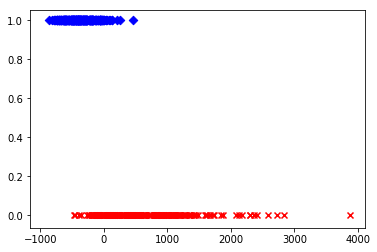

In [30]:
import matplotlib.pyplot as plt                 
from sklearn.decomposition import PCA 

pca = PCA(n_components = 0.2)    # 设置方差阈值，只取方差超过0.2的
reduced_x = pca.fit_transform(df) # transform 的方法, 它可以用来降低维度
print(pca.explained_variance_ratio_)

if len(pca.explained_variance_ratio_) == 1:
    red_x,red_y=[],[]
    blue_x,blue_y=[],[]
    
    for i in range(len(reduced_x)):
        if df.iloc[i,-1] ==0:
            red_x.append(reduced_x[i][0])
           

        elif df.iloc[i,-1] ==1:
            blue_x.append(reduced_x[i][0])
   

    #可视化
    plt.scatter(red_x,np.zeros_like(red_x),c='r',marker='x')
    plt.scatter(blue_x,np.ones_like(blue_x),c='b',marker='D')

    plt.show()
if len(pca.explained_variance_ratio_) == 2:
    red_x,red_y=[],[]
    blue_x,blue_y=[],[]
    for i in range(len(reduced_x)):
        if df.iloc[i,-1] ==0:
            red_x.append(reduced_x[i][0])
            red_y.append(reduced_x[i][1])

        elif df.iloc[i,-1] ==1:
            blue_x.append(reduced_x[i][0])
            blue_y.append(reduced_x[i][1])

    #可视化
    plt.scatter(red_x,red_y,c='r',marker='x')
    plt.scatter(blue_x,blue_y,c='b',marker='D')

    plt.show()



[0.92461872 0.05306648]


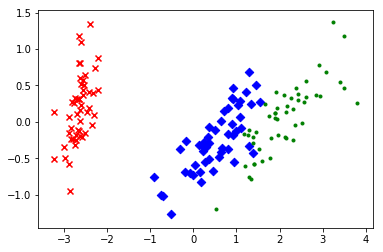

In [4]:
import matplotlib.pyplot as plt                 #加载matplotlib用于数据的可视化
from sklearn.decomposition import PCA           #加载PCA算法包
from sklearn.datasets import load_iris

data=load_iris()
y=data.target
x=data.data
pca=PCA(n_components=2)     #加载PCA算法，设置降维后主成分数目为2
reduced_x=pca.fit_transform(x)#对样本进行降维
print(pca.explained_variance_ratio_)
red_x,red_y=[],[]
blue_x,blue_y=[],[]
green_x,green_y=[],[]


for i in range(len(reduced_x)):
    if y[i] ==0:
        red_x.append(reduced_x[i][0])
        red_y.append(reduced_x[i][1])

    elif y[i]==1:
        blue_x.append(reduced_x[i][0])
        blue_y.append(reduced_x[i][1])

    else:
        green_x.append(reduced_x[i][0])
        green_y.append(reduced_x[i][1])

#可视化
plt.scatter(red_x,red_y,c='r',marker='x')
plt.scatter(blue_x,blue_y,c='b',marker='D')
plt.scatter(green_x,green_y,c='g',marker='.')
plt.show()
